In [0]:
# !pip install konlpy

In [1]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# from nltk.tokenize import sent_tokenize
from collections import Counter
import pandas as pd
import re
from konlpy.tag import Okt
import pickle
import matplotlib.pyplot as plt
import numpy as np
okt = Okt()

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


# 데이터를 불러온다


In [0]:
book_data = pd.read_csv("/content/drive/My Drive/colab/BOOK_DATA/DATA/books_df.csv", index_col=0)

In [4]:
book_data.head(5)

,제목,Text,레벨,점수,키워드
0,가난한 사람들을 위한 의사 장기려,['날 저녁 부산 병원 원장 실 환자 명 노크 . 문 사람 병원 입원 창의 농부 ....,초등1,5,"['의사', '연구', '생명', '가난', '사명감', '희생']"
1,간서치 형제의 책 읽는 집,['김 서린 방 형 나이 아우 책상 책 . 소리 책 벽 한기 . 한기 기운 . 이 ...,초등4,5,"['이덕무', '이공무', '독서', '가난', '서자']"
2,강아지로 변한 날,['그 얘기 무슨 얘기 보름달 사람 개 개 사람 누가 앞 순영 정민 강아지 날 중이...,초등1,4,"['습관', '바른말', '고운말', '비속어', '언어']"
3,"강치가 들려주는 우리 땅, 독도 이야기",['제 장강 치 사냥꾼 나카이 독도 강치 살육 바다 새색시 . 바람 점 불지 파도 ...,초등5,8,"['독도', '일본', '역사', '자연', '지리', '보호']"
4,개구쟁이 얼룩이,['민희 개 순돌이 새끼 세 마리 . 강아지 모두 엄마 품 젖 시작 . 민희 식구 ...,유치,2,"['장난', '단점', '사랑', '이해심', '사랑']"


# 10진분류에서 정확도가 잘 나오지 않아 카테고리를 5개로 줄임

In [0]:
five_score = []
for i in book_data['점수'].values:
  if i < 3:
    five_score.append(1)
  elif i < 5:
    five_score.append(2)
  elif i < 7:
    five_score.append(3)
  elif i < 8:
    five_score.append(4)
  else:
    five_score.append(5)

In [0]:
book_data['점수'] = five_score # 5진분류

In [0]:
five_score = pd.get_dummies(book_data, columns=['점수'], prefix='점수') # 원핫 인코딩

In [0]:
y_5 = five_score.iloc[:,4:] # 라벨값을 변수에 담음

--------------------------

In [0]:
book_text = book_data['Text'] # 변수이름을 새로 받음

#한국어 불용어사전
stop_words = open("/content/drive/My Drive/colab/BOOK_DATA/DATA/korstopwords.txt",encoding="utf-8")
stop_words = stop_words.readlines()
stop_words = [line.rstrip() for line in stop_words]

In [0]:
# 텍스트의 형태 [단어, 단어, 단어] / 정확도가 더 높은 데이터의 형태
def clean_text_word(data):
  result = okt.nouns(data)
  book_list = []
  for i in result:
    if len(i) > 1 and not i in stop_words:
      book_list.append(i)
  return book_list

In [0]:
book_text = book_text.apply(lambda x: x.split(".")) # .기준으로 문장을 나눠준다.

# text의 형태 ("단어 단어 단어, 단어 단어")
def clean_text(data):
  result = []
  for w in data:
    result.append(okt.nouns(w))
    book_list = []
  for s in result:
    list_full = []
    for word in s:
      if len(word) > 1 and not word in korwords:
        list_full.append(word)
    book_list.append(list_full)
  return book_list

def join_sentence(data):
  result = []
  for one_list in data:
    if len(one_list) > 1:
      result.append(" ".join(one_list))
  return result

In [0]:
book_text_wordtoken = book_text.apply(clean_text_word)

In [0]:
#두번째의 함수를 이용한 전처리
# book_text_v1 = book_text.apply(clean_text)
# book_text_v1 = book_text_v1.apply(join_sentence)

In [0]:
train_length = book_text_wordtoken.apply(len)

<function matplotlib.pyplot.show>

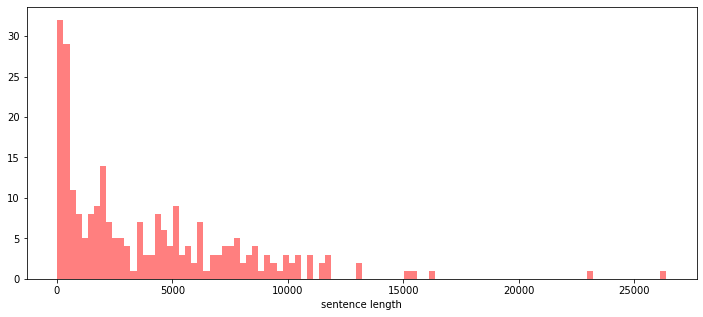

In [13]:
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 100, alpha = 0.5, color = 'r')
plt.xlabel('sentence length')
plt.ylabel('')
plt.show

In [14]:
print('max length :', np.max(train_length))
print('min length :', np.min(train_length))
print('mean length :', np.mean(train_length))
print('50 % percentile :', np.percentile(train_length, 50))
print('85 % percentile :', np.percentile(train_length, 85))
print('std length :', np.std(train_length))

max length : 26386
min length : 21
mean length : 3963.7312252964425
50 % percentile : 2520.0
85 % percentile : 8032.5999999999985
std length : 4036.726389485722


In [0]:
X = book_text_wordtoken
y = book_data['점수'].values

In [0]:
num_words = 30000
max_len = 3500
emb_size = 128

In [0]:
tok = Tokenizer(num_words = num_words)
tok.fit_on_texts(list(X))

In [0]:
X = tok.texts_to_sequences(X)

In [0]:
X = sequence.pad_sequences(X, maxlen = max_len, padding='post')
# X_test = sequence.pad_sequences(test, maxlen = max_len, padding = 'post')

In [24]:
inp = Input(shape=(max_len, )) #maxlen=200 as defined earlier
x = Embedding(num_words, emb_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
file_path = 'save_best'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 30)

In [29]:
batch_size = 32
epochs = 100
model.fit(X,y_5, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 227 samples, validate on 26 samples
Epoch 1/100





227/227 [==============================] - 61s 267ms/step - loss: 1.6075 - acc: 0.2159 - val_loss: 1.6082 - val_acc: 0.1923
Epoch 2/100
227/227 [==============================] - 59s 258ms/step - loss: 1.5945 - acc: 0.4537 - val_loss: 1.6013 - val_acc: 0.1538
Epoch 3/100
227/227 [==============================] - 59s 258ms/step - loss: 1.5788 - acc: 0.5463 - val_loss: 1.5915 - val_acc: 0.1538
Epoch 4/100
227/227 [==============================] - 58s 257ms/step - loss: 1.5547 - acc: 0.5419 - val_loss: 1.5783 - val_acc: 0.1923
Epoch 5/100
227/227 [==============================] - 58s 256ms/step - loss: 1.5186 - acc: 0.5242 - val_loss: 1.5425 - val_acc: 0.1923
Epoch 6/100
227/227 [==============================] - 59s 259ms/step - loss: 1.4653 - acc: 0.5727 - val_loss: 1.4934 - val_acc: 0.5769
Epoch 7/100
227/227 [================

In [0]:
batch_size = 32
epochs = 100
model.fit(X,y_5, batch_size=batch_size, epochs=epochs, validation_split=0.1)